# DCGAN trained on CIFAR10 dataset

Implementing a DCGAN to generate images, trained on CIFAR10 dataset

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Activation, BatchNormalization, Flatten, Input, Reshape
from keras.layers import UpSampling2D, Conv2D, MaxPool2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.layers import LeakyReLU
from keras.datasets import cifar10

import numpy as np
import matplotlib.pyplot as plt
import sys

Using TensorFlow backend.
/home/hdidwania/Programming/general_ml/general_ml_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hdidwania/Programming/general_ml/general_ml_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [23]:
class DCGAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.noise_dim = 100
        
        optimizer_d = Adam(lr=0.0002,beta_1=0.5)
        optimizer_g = Adam(lr=0.0002,beta_1=0.5)
        
        #Discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer_d,
                                   metrics=['accuracy'])
        
        #Generator
        self.generator = self.build_generator()
        
        z = Input(shape=(self.noise_dim,))
        generated_img = self.generator(z)
        self.discriminator.trainable= False
        discriminator_result = self.discriminator(generated_img)
        
        #Combined model
        self.combined = Model(z, discriminator_result)
        print("Combined Model:")
        print(self.combined.summary())
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=optimizer_g)
        
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(1024*2*2, 
                        input_dim=self.noise_dim, 
                        kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization(momentum=0.5))
        model.add(Activation(activation='relu'))
        model.add(Reshape((2,2,1024), input_shape=(1024*2*2,)))
        model.add(UpSampling2D(size=(2,2)))
        model.add(Conv2DTranspose(512, 
                         kernel_size=(5,5), 
                         padding='same', 
                         kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization(momentum=0.5))
        model.add(Activation(activation='relu'))
        model.add(UpSampling2D(size=(2,2)))
        model.add(Conv2DTranspose(256, 
                         kernel_size=(5,5), 
                         padding='same', 
                         kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization(momentum=0.5))
        model.add(Activation(activation='relu'))
        model.add(UpSampling2D(size=(2, 2)))
        model.add(Conv2DTranspose(128, 
                         kernel_size=(5, 5), 
                         padding='same', 
                         kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization(momentum=0.5))
        model.add(Activation(activation='relu'))
        model.add(UpSampling2D(size=(2, 2)))
        model.add(Conv2DTranspose(3, 
                         kernel_size=(5, 5), 
                         padding='same', 
                         kernel_initializer='glorot_uniform'))
        model.add(Activation('tanh'))
        print("Generator:")
        print(model.summary())
        return model
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(
                Conv2D(64, 
                kernel_size=(5, 5),
                strides=(2,2),
                padding='same',
                kernel_initializer='glorot_uniform',
                input_shape=self.img_shape))
        model.add(BatchNormalization(momentum=0.5))
        model.add(LeakyReLU(0.2))
        model.add(
                Conv2D(128, 
                kernel_size=(3, 3),
                strides=(2,2),
                padding='same',
                kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization(momentum=0.5))
        model.add(LeakyReLU(0.2))
        model.add(
                Conv2D(256, 
                kernel_size=(3, 3),
                strides=(2,2),
                padding='same',
                kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization(momentum=0.5))
        model.add(LeakyReLU(0.2))
        model.add(Flatten())
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        print("Discriminator:")
        print(model.summary())
        return model
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        
        #Load dataset
        (X_train, _), (_, _) = cifar10.load_data()
        
        #Rescale between -1 to 1
        X_train = X_train/127.5 - 1
        
        valid = np.ones((batch_size,1))
        fake = np.ones((batch_size,1))
        
        self.d_losses = []
        self.g_losses = []
        
        for epoch in range(epochs):
            #Train discriminator
            
            #Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.uniform(0, 1, (batch_size, self.noise_dim))
            
            generated_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(generated_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            #Train generator
            
            noise = np.random.uniform(0, 1, (batch_size, self.noise_dim))
            
            g_loss = self.combined.train_on_batch(noise, valid)
            
            print("\r%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss), end="")
            sys.stdout.flush()
            
            self.d_losses.append(d_loss[0])
            self.g_losses.append(g_loss)
            
            if(epoch % sample_interval == 0):
                self.sample_images(epoch)
                
        return self.d_losses, self.g_losses
        
    def sample_images(self, epoch):
        print("")
        r, c = 5, 5
        noise = np.random.uniform(0,1,(r*c, self.noise_dim))
        generated_imgs = self.generator.predict(noise)
            
        #Rescale images between 0 to 1
        generated_imgs = 0.5*generated_imgs+0.5
            
        fig, axs = plt.subplots(r,c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(generated_imgs[cnt,:,:,:])
                axs[i,j].axis('off')
                cnt+=1
        fig.savefig("images/%d.png" % epoch)
        plt.close()
            
    def show_final(self):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r*c, self.noise_dim))
        generated_imgs = self.generator.predict(noise)
        
        #Rescale to 0 to 1
        generated_imgs = 0.5 * generated_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(generated_imgs[cnt,:,:,:])
                axs[i,j].axis('off')
                cnt +=1
        plt.show()
        plt.close()

In [30]:
dcgan = DCGAN()

Discriminator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization_40 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
batch_normalization_41 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 256)         295168

In [31]:
d_losses, g_losses = dcgan.train(epochs=300, batch_size=8, sample_interval=100)

/home/hdidwania/Programming/general_ml/general_ml_env/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.541215, acc: 81.25%] [G loss: 0.223188]
100 [D loss: 0.000472, acc: 100.00%] [G loss: 0.000003]
200 [D loss: 0.000084, acc: 100.00%] [G loss: 0.000001]
299 [D loss: 0.000046, acc: 100.00%] [G loss: 0.000000]

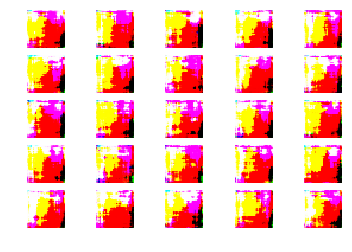

In [32]:
dcgan.show_final()

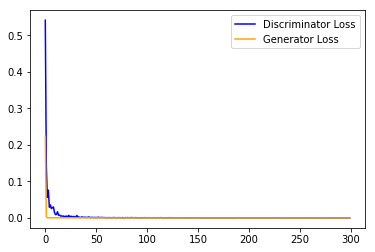

In [33]:
plt.plot(d_losses, color='blue')
plt.plot(g_losses, color='orange')
plt.legend(["Discriminator Loss", "Generator Loss"])
plt.show()